In [25]:
%matplotlib inline

import os, sys, time
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
import utils.bosch_functions as bosch_functions
from utils.validation_tools import score_MCC, MCC, create_validation_index
from utils.models import CombinedModel

data_path = '/home/ymm/bosch/'

train_num_file   = 'train_numeric.csv'
train_cat_file   = 'train_categorical.csv'
train_date_file  = 'train_date.csv'
test_num_file    = 'test_numeric.csv'
test_cat_file    = 'test_categorical.csv'
test_date_file   = 'test_date.csv'

sample_submission_file   = 'sample_submission.csv'


start_time_column_name = 'L0_S0_D1'
id_column_name = 'Id'
dep_var_name = 'Response'

In [2]:
bin_num = 1 ## number of bins to separate data by start_time
tmp_train, tmp_test, bins, bin_names = bosch_functions.create_grouped_index_df(bin_num)

data loading takes  72.4  seconds.


In [3]:
## create the skipped row numbers
none_selected_window_num = [np.NaN]
skipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
skipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()

train_cat_cols  = pd.read_csv(join(data_path, train_cat_file), index_col=id_column_name, nrows=0)
train_date_cols = pd.read_csv(join(data_path, train_date_file), index_col=id_column_name, nrows=0)
train_num_cols  = pd.read_csv(join(data_path, train_num_file), index_col=id_column_name, nrows=0)

regular_data_path = '/home/ymm/kaggle/bosch/data_1_bins_cross_fit_xgb_models/data_bin_0_models'

### R&D work

Based on the knowledge from tree-based models, the numerical data provides the majority of information. So it
is a good start to understand the regular data and feature importance.

    1. use all the numerical data and only first 50,000 rows
    2. try to build a LR model and understand the numerical data

In [4]:
## select all the numerical columns and try to use LR
train_num = pd.read_csv(join(data_path, train_num_file),   index_col='Id', skiprows=skipped_train_row_num, nrows=50000)
train_dat = pd.read_csv(join(data_path, train_date_file),  index_col='Id', skiprows=skipped_train_row_num, nrows=50000)

In [5]:
## remove columns that mostly just NaN
## remove columns that mostly just NaN
train_num.fillna(-2., inplace=True)
train_dat.fillna(-2., inplace=True)

In [6]:
start_time = time.time()
train_num_corr = train_num.corr()
train_dat_corr = train_dat.corr()
print 'finish calculating correlation using {} seconds'.format(round(time.time() - start_time, 0))

finish calculating correlation using 416.0 seconds


In [7]:
print train_num_corr.shape, train_dat_corr.shape

(969, 969) (1156, 1156)


In [8]:
train_dat_corr

,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,L0_S0_D19,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
L0_S0_D1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D11,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619
L0_S0_D19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.111016,0.111016,0.111016,0.111016,0.111016,0.157619,0.157619,0.157619,0.157619,0.157619


In [9]:
start_index = 0
thres = 0.5
num_removed_cols = set()
dat_removed_cols = set()

for column in train_num_corr.columns:
    start_index += 1
    if column not in num_removed_cols:
        for index, value in enumerate(train_num_corr[column][start_index:]):
            if abs(value) > thres:
                num_removed_cols.add(train_num_corr.columns[(index + start_index)])
               
start_index = 0           
for column in train_dat_corr.columns:
    start_index += 1
    if column not in dat_removed_cols:
        for index, value in enumerate(train_dat_corr[column][start_index:]):
            if abs(value) > thres:
                dat_removed_cols.add(train_dat_corr.columns[(index + start_index)])

In [11]:
print len(num_removed_cols), len(dat_removed_cols), train_num_corr.shape[1], train_dat_corr.shape[1]

 838 1008 969 1156


In [12]:
max_corr_fea = train_num_corr['Response'][:-1].argmax()
min_corr_fea = train_num_corr['Response'][:-1].argmin()

In [13]:
print train_num_corr['Response'][:-1].max(), max_corr_fea, '\n', train_num_corr['Response'][:-1].min(), min_corr_fea

0.0815383637123 L1_S25_F2758 
-0.0434625285261 L3_S33_F3865


In [14]:
train_num[max_corr_fea].value_counts()

-2.000    49997
 0.309        2
-0.441        1
Name: L1_S25_F2758, dtype: int64

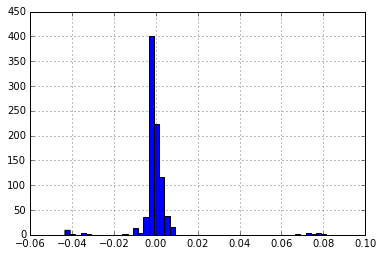

In [15]:
train_num_corr['Response'][:-1].hist(bins=50)

In [16]:
selected_num_col_names = [col for col in train_num.columns if col not in num_removed_cols]
selected_dat_col_names = [col for col in train_dat.columns if col not in dat_removed_cols]

In [17]:
print len(selected_num_col_names), len(selected_dat_col_names)

131 148


In [18]:
selected_num_col_names.extend(['Id', 'Response'])
selected_dat_col_names.extend(['Id'])

In [19]:
start_time = time.time()
full_train_num  = pd.read_csv(join(data_path, train_num_file),    index_col='Id', skiprows=skipped_train_row_num, usecols=selected_num_col_names)
full_train_cat  = pd.read_csv(join(data_path, train_date_file),   index_col='Id', skiprows=skipped_train_row_num, usecols=selected_dat_col_names)
print 'finish loading full data using {} seconds'.format(round(time.time() - start_time, 0))

finish loading full data using 58.0 seconds


In [20]:
tmp_train_num = full_train_num.copy()
tmp_train_cat = full_train_cat.copy()

## remove columns that mostly just NaN
tmp_train_num.fillna(-2., inplace=True)
tmp_train_cat.fillna(-2., inplace=True)

print tmp_train_num.shape, tmp_train_cat.shape

(673861, 131) (673861, 148)


In [22]:
combined_train = pd.merge(tmp_train_num, tmp_train_cat, how='outer', left_index=True, right_index=True)

In [23]:
print combined_train.shape, dep_var_name in combined_train.columns
combined_train.head()

(673861, 279) True


,L0_S0_F0,L0_S0_F4,L0_S0_F8,L0_S0_F16,L0_S0_F20,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S4_F104,L0_S6_F118,...,L3_S32_D3852,L3_S35_D3886,L3_S38_D3953,L3_S39_D3966,L3_S42_D4029,L3_S42_D4045,L3_S42_D4049,L3_S42_D4053,L3_S42_D4057,L3_S46_D4135
Id,,,,,,,,,,,,,,,,,,,,,
4,0.030,-0.197,0.118,0.020,-0.273,-0.271,0.167,-0.213,-0.001,-2.000,...,-2.0,87.29,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
7,0.088,0.003,0.161,-0.225,0.250,0.057,-0.079,-0.013,-2.000,-0.336,...,-2.0,1624.42,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
9,-0.036,0.294,0.074,-0.026,-0.253,0.147,-0.007,-0.013,-0.038,-2.000,...,-2.0,-2.00,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
11,-0.055,0.294,0.118,-0.169,0.042,-0.012,-0.046,-2.000,0.021,-2.000,...,-2.0,-2.00,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
13,0.003,0.294,0.031,-0.005,-0.035,-0.051,-0.074,-2.000,0.015,-2.000,...,-2.0,-2.00,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [26]:
############## Section of regular validation #######################
train_index, valid_index = create_validation_index(combined_train, 0.3, dep_var_name, True)
valid_data = combined_train.ix[valid_index]
tmp_train  = combined_train.ix[train_index]

In [27]:
y = tmp_train[dep_var_name].values
X = tmp_train.drop(dep_var_name, axis=1)

valid_y = valid_data[dep_var_name].values
valid_X = valid_data.drop(dep_var_name, axis=1)

In [28]:
print X.shape, valid_X.shape

(471704, 278) (202157, 278)


In [29]:
C = 0.01

In [30]:
start_time = time.time()
LR_clf = LogisticRegression(C = C, class_weight='balanced', n_jobs = -1, penalty='l2')
LR_clf.fit(X, y)
print 'finish training LR model using {} seconds'.format(round(time.time() - start_time, 0))

finish training LR model using 966.0 seconds


In [31]:
pred = LR_clf.predict_proba(valid_X)[:, 1]

print 'result from using constant fraction: \n', score_MCC(valid_y, pred)
print '\n \n'
print 'result from using flexsible threshold:', CombinedModel.mcc_eval_func(valid_y, pred)

result from using constant fraction: 
mean of groud truth: 0.00535227570651
threshold for preds: 0.909018661194
0.0364323691765

 

result from using flexsible threshold: (0.0703437307457835, 0.7811978538393378)


In [32]:
coef_l1_LR = LR_clf.coef_.ravel()

In [33]:
len(coef_l1_LR)

278

(array([ 254.,    2.,    5.,    0.,    0.,    2.,    0.,    1.,    0.,
           0.,    2.,    2.,    1.,    2.,    0.,    2.,    1.,    0.,
           0.,    0.,    1.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.,    0.,    0.,    0.,    1.]),
 array([  3.15937207e-05,   2.56208458e-02,   5.12100979e-02,
          7.67993499e-02,   1.02388602e-01,   1.27977854e-01,
          1.53567106e-01,   1.79156358e-01,   2.04745610e-01,
          2.30334862e-01,   2.55924114e-01,   2.81513366e-01,
          3.07102619e-01,   3.32691871e-01,   3.58281123e-01,
          3.83870375e-01,   4.09459627e-01,   4.35048879e-01,
          4.60638131e-01,   4.86227383e-01,   5.11816635e-01,
          5.37405887e-01,   5.62995139e-01,   5.88584391e-01,
          6.14173643e-01,   6.39762895e-01,   6.65352147e-01,
          6.90941399e-01,   7.16530652e-01

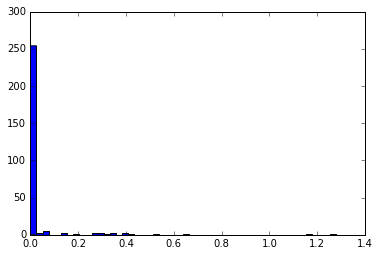

In [40]:
plt.hist(abs(coef_l1_LR), bins=50)

(array([   1.,    0.,    0.,    1.,    0.,    0.,    1.,    0.,    0.,
           1.,    1.,    1.,    1.,    0.,    1.,    3.,  252.,    3.,
           2.,    0.,    1.,    0.,    0.,    1.,    1.,    3.,    0.,
           2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    0.,    1.]),
 array([-0.64847628, -0.60991687, -0.57135746, -0.53279805, -0.49423864,
        -0.45567923, -0.41711983, -0.37856042, -0.34000101, -0.3014416 ,
        -0.26288219, -0.22432278, -0.18576337, -0.14720396, -0.10864455,
        -0.07008514, -0.03152573,  0.00703368,  0.04559309,  0.0841525 ,
         0.12271191,  0.16127132,  0.19983073,  0.23839014,  0.27694955,
         0.31550896,  0.35406837,  0.39262778,  0.43118719,  0.4697466 ,
         0.50830601,  0.54686541,  0.58542482,  0.62398423,  0.66254364,
         0.70110305,  0.73966246,  0.77822187,  0.81678128,  0.85534069,
         0.89390

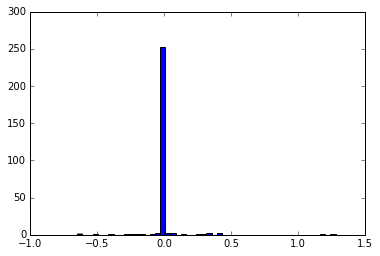

In [38]:
plt.hist(coef_l1_LR, bins=50)

In [35]:
print np.argmax(coef_l1_LR), np.argmin(coef_l1_LR)

11 10


In [36]:
sorted_index = np.argsort(abs(coef_l1_LR))

In [42]:
coef_l1_LR[sorted_index]

array([ -3.15937207e-05,   3.54970429e-05,   4.57195874e-05,
        -7.50858265e-05,  -8.34106231e-05,  -8.78259159e-05,
        -1.81626045e-04,  -2.59894257e-04,   4.26605795e-04,
        -4.54853765e-04,  -4.70149774e-04,   5.05970896e-04,
        -5.20437016e-04,  -9.10529190e-04,  -9.53531201e-04,
         1.97979829e-03,  -2.22590469e-03,  -2.24187066e-03,
        -2.27893066e-03,   2.35787186e-03,   7.74244228e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,  -9.75568133e-03,  -9.75568133e-03,
        -9.75568133e-03,

In [41]:
coef_l1_LR[sorted_index][-17:]

array([ 0.14918519, -0.15315281, -0.1886772 ,  0.2600551 , -0.26087357,
       -0.29526846,  0.29792955,  0.33187008,  0.33828917,  0.35115122,
        0.39860284, -0.40934682,  0.42208408, -0.53065398, -0.64847628,
        1.17158913,  1.2794942 ])

In [39]:
sorted_index[-17:]

array([  0, 124,   6,   5,  19,   3,  15,  13,  12,  14, 123, 126,  17,
         1,  10, 127,  11])

In [45]:
print X.columns[np.argmax(coef_l1_LR)], tmp_train_num.columns[np.argmin(coef_l1_LR)]

L0_S8_F146 L0_S8_F144


In [48]:
X.columns[sorted_index][-20:]

Index([u'L2_S26_F3036', u'L3_S30_F3564', u'L1_S24_F1512', u'L0_S0_F0',
       u'L3_S29_F3315', u'L0_S1_F28', u'L0_S1_F24', u'L1_S25_F1855',
       u'L0_S0_F16', u'L0_S12_F330', u'L0_S10_F219', u'L0_S9_F155',
       u'L0_S11_F282', u'L2_S28_F3222', u'L3_S31_F3834', u'L1_S24_F1118',
       u'L0_S0_F4', u'L0_S8_F144', u'L3_S32_F3850', u'L0_S8_F146'],
      dtype='object')

In [ ]:
['L3_S31_F3834', 'L1_S25_F1855', 'L0_S8_F144', 'L0_S8_F146', 'L3_S32_F3850']

In [47]:
X.columns[sorted_index[-17:]]

Index([u'L0_S0_F0', u'L3_S29_F3315', u'L0_S1_F28', u'L0_S1_F24',
       u'L1_S25_F1855', u'L0_S0_F16', u'L0_S12_F330', u'L0_S10_F219',
       u'L0_S9_F155', u'L0_S11_F282', u'L2_S28_F3222', u'L3_S31_F3834',
       u'L1_S24_F1118', u'L0_S0_F4', u'L0_S8_F144', u'L3_S32_F3850',
       u'L0_S8_F146'],
      dtype='object')

In [49]:
tmp_train_num['L0_S0_F0'].value_counts()

 0.023    23002
 0.010    22680
 0.016    22643
 0.003    22524
-0.003    22340
 0.030    22212
-0.010    22074
 0.036    21612
-0.016    21262
 0.043    21107
-0.023    20614
-0.029    19965
 0.049    19772
-0.036    19040
 0.056    18924
-0.042    18295
 0.062    18038
-0.049    17045
 0.069    16509
-0.055    15923
 0.075    15314
-0.062    14954
-0.068    13880
 0.082    13712
-0.075    12752
 0.088    12467
-0.082    11705
 0.095    11210
-0.088    10320
 0.101     9988
          ...  
 0.258       65
-0.317       63
-0.310       47
 0.265       35
-0.323       30
-0.330       29
-0.350       18
-0.336       16
-0.343       14
-0.356       13
 0.271        8
-0.389        7
-0.382        7
-0.395        6
 0.278        6
-0.363        6
-0.421        6
-0.402        5
-0.369        5
-0.408        4
-0.415        3
-0.376        3
-0.428        1
-0.474        1
-0.435        1
-0.506        1
-0.565        1
-0.461        1
-0.448        1
-0.467        1
Name: L0_S0_F0, dtype: i

In [89]:
tmp_train_num['L0_S8_F144'].value_counts()

-0.157    461446
 0.343    211003
-1.000       835
-0.657       577
Name: L0_S8_F144, dtype: int64

In [88]:
tmp_train_num['L3_S32_F3850'].value_counts()

-1.000    659534
-0.005       628
 0.043       535
-0.018       479
 0.019       462
-0.030       446
 0.007       446
 0.031       412
-0.006       385
-0.055       373
 0.018       329
-0.042       320
 0.030       291
-0.031       288
 0.006       279
 0.055       276
-0.019       249
 0.079       247
-0.043       231
-0.054       230
-0.004       216
 0.005       210
 0.067       206
-0.067       199
 0.056       198
 0.020       184
 0.054       172
 0.068       168
-0.080       165
 0.032       164
           ...  
-0.082         5
 0.073         5
 0.017         4
-0.102         4
-0.162         4
 0.036         4
 0.084         3
 0.104         3
-0.045         3
-0.187         3
 0.047         3
-0.173         3
-0.404         3
 0.041         2
 0.106         2
-0.119         2
-0.646         2
-0.096         2
-0.060         2
-0.126         2
-0.024         2
 0.072         2
-0.049         1
-0.112         1
-0.439         1
 0.076         1
-0.161         1
-0.098        

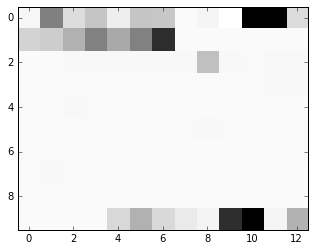

In [76]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(coef_l1_LR.reshape(10, 13)), interpolation='nearest',
                   cmap='binary', vmax=1, vmin=0)

In [68]:
pred = LR_clf.predict_proba(valid_X)[:, 1]

print 'result from using constant fraction:', score_MCC(valid_y, pred)
print '\n \n'
print 'result from using flexsible threshold:', CombinedModel.mcc_eval_func(valid_y, pred)

result from using constant fraction: mean of groud truth: 0.00535227570651
threshold for preds: 0.901654751382
0.0401491199222

 

result from using flexsible threshold: (0.06933770124631451, 0.7563694679020283)
